# Walkthrough - Gamma n Mutual Infor



In [1]:
import sys, os

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

import warnings
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.dist import DataParams, Inputs

# Kernel Dependency measure
from pysim.kernel.hsic import HSIC
from pysim.kernel.utils import estimate_gamma, GammaParam

# RBIG IT measures
from models.ite_algorithms import run_rbig_models

# Plotting
from visualization.distribution import plot_scorer

# experiment helpers
from tqdm import tqdm

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-talk'])
warnings.filterwarnings('ignore') # get rid of annoying warnings
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

## Datasets

* Samples - [500, 1K, 5K, 10K, 30K, 50K]
* Dimensions - [ 2, 3, 10, 50, 100]
* trials - `1:5`
* IT measures - Mutual Information
* Distributions - [Gaussian, T-Student]

## Example Gaussian Distribution: 2D

In [2]:
from typing import List, Tuple
    
def gen_dist_data(params: DataParams) -> Tuple[np.ndarray, np.ndarray]:
    """Helper function to generate data"""
    # initialize dataloader
    dataloader = DistData(distribution=params.dataset)
    return dataloader.get_data(
        samples=params.samples,
        dimensions=params.dimensions,
        std=params.std,
        trial=params.trial,
        nu=params.nu
    )

#### 1. Generate Data

In [3]:
example_params = DataParams()
example_params

Dataset: gauss
Samples: 100
Dimensions: 2
Standard Deviation: 1
Nu: 1
Trial: 1

In [4]:
example_params.generate_data?

Signature: example_params.generate_data() -> data.dist.Inputs
Docstring:
Helper function to generate data using the 
parameters above.
File:      ~/projects/2019_hsic_align/src/data/dist.py
Type:      method


In [5]:
Inputs?

Init signature: Inputs(X: numpy.ndarray, Y: numpy.ndarray, mutual_info: float)
Docstring:     
Helpful data holder which stores:

X : np.ndarray, (n_samples, n_features)

Y : np.ndarray, (n_samples, n_features)

mutual_info : float
    the mutual information value
File:           ~/projects/2019_hsic_align/src/data/dist.py
Type:           type
Subclasses:     


In [6]:
inputs = example_params.generate_data()

## HSIC Algorithms

In [7]:
from typing import Optional
from dataclasses import dataclass

@dataclass
class ModelParams:
    kernel: str = 'rbf'
    bias: bool = True
    gamma_X: Optional[float] = None
    gamma_Y: Optional[float] = None
    subsample: Optional[int] = None


    def get_score(
        self, X: np.ndarray, Y: np.ndarray, method: str='hsic', **kwargs
    ) -> float:

        if method == 'hsic':
            self.normalize = False     # HSIC
            self.center = True       
        elif method == 'ka':
            # change params for Kernel Alignment
            self.normalize = True
            self.center = False    
        elif method == 'cka':
            # change params for centered Kernel Alignment
            self.normalize = True
            self.center = True
        else:
            raise ValueError(f"Unrecognized hsic method: {method}")

        # initialize HSIC model
        clf_hsic = HSIC(
            kernel=self.kernel, 
            center=self.center,
            subsample=self.subsample,
            bias=self.bias,
            gamma_X=self.gamma_X,
            gamma_Y=self.gamma_Y,
            **kwargs
        )

        # calculate HSIC return scorer
        clf_hsic.fit(X, Y);

        # return score
        return clf_hsic.score(X, normalize=self.normalize)

## Experiment I - Mutual Info vs. HSIC

We are looking at different "HSIC scorers". They are:

---
**HSIC**

$$HSIC = \frac{1}{n(n-1)}\langle K_xH,K_yH \rangle_F$$

Notice: we have the centered kernels, $K_xH$ and no normalization.

---
**TKA** 

$$TKA = \frac{\langle K_x,K_y \rangle_F}{||K_x||_F||K_y||_F}$$

Notice: We have the uncentered kernels and a normalization factor.

---
**cTKA**

$$cTKA = \frac{\langle K_xH,K_yH \rangle_F}{||K_xH||_F||K_yH||_F}$$

Notice: We have the centered kernels and a normalization factor.

In [8]:
DataParams?

Init signature:
DataParams(
    dataset: str = 'gauss',
    samples: int = 100,
    dimensions: int = 2,
    std: int = 1,
    trial: int = 1,
    nu: int = 1,
) -> None
Docstring:     
A dataclass which holds all of the options to 
generate datasets. 

Parameters
-------
trials : int, default=1
    {1, 2, 3, 4, 5}

samples : int, default=100
    {50, 100, 500, 1_000, 5_000}

dimensions : int, default = 2
    {2, 3, 10, 50, 100}

std : int, default=2
    {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
    
nu : int, default = 2 
    {1, 2, 3, 4, 5, 6, 7, 8, 9}
File:           ~/projects/2019_hsic_align/src/data/dist.py
Type:           type
Subclasses:     


**[source](https://stackoverflow.com/questions/5228158/cartesian-product-of-a-dictionary-of-lists)**

In [9]:
import itertools

def dict_product(dicts):
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts.keys(), x)) for x in itertools.product(*dicts.values()))

In [10]:
# experimental parameters
parameters = {
    "trials" : [1, 2, 3, 4, 5],
    "samples" : [50, 100, 500, 1_000, 5_000],
    "dimensions" : [2, 3, 10, 50, 100],
    "std" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    "scorers" : ['hsic', 'ka', 'cka'],
    "gamma_estimators" : [
        ('silverman',None, None),
        ('scott', None, None),
        *[('median', x, None) for x in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]
    ]
}

In [11]:
n_params = len(list(dict_product(parameters)))

for i, iparams in zip(tqdm(range(n_params)), dict_product(parameters)):
    break

  0%|          | 0/45375 [00:00<?, ?it/s]


In [12]:
next(dict_product(parameters))

{'trials': 1,
 'samples': 50,
 'dimensions': 2,
 'std': 1,
 'scorers': 'hsic',
 'gamma_estimators': ('silverman', None, None)}

In [ ]:
from tqdm import tqdm
import itertools



# experimental parameters
parameters = {
    "trials" : [1, 2, 3, 4, 5],
    "std" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    "scorers" : ['hsic', 'ka', 'cka'],
    "gamma_estimators" : [
        ('silverman',None, None),
        ('scott', None, None),
        *[('median', x, None) for x in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]
    ],
    "dimensions" : [2, 3, 10, 50, 100],
    "samples" : [50, 100, 500, 1_000, 5_000],
}


n_params = len(list(dict_product(parameters)))

# init hsic model class
hsic_model = ModelParams()

# results dataframe
scores_df = pd.DataFrame()


# ==================
# Gamma Estimators
# ==================    
for i, iparams in zip(tqdm(range(n_params)), dict_product(parameters)):
        
        # ================
        # DATA
        # ================    
        dist_data = DataParams()

        # set params
        dist_data.trials = iparams['trials']
        dist_data.std = iparams['std']
        dist_data.samples = iparams['samples']
        dist_data.dimensions = iparams['dimensions']


        # generate data
        inputs = dist_data.generate_data()

        # ====================
        # Gamma Estimator
        # ====================
        gamma_est = GammaParam(*iparams['gamma_estimators'])

        # estimate sigma
        gamma_X = estimate_gamma(
            X=inputs.X, 
            method=gamma_est.method,
            scale=gamma_est.scale,
            percent=gamma_est.percent
        )
        gamma_Y = estimate_gamma(
            X=inputs.Y, 
            method=gamma_est.method,
            scale=gamma_est.scale,
            percent=gamma_est.percent
        )
        # ====================
        # HSIC Model
        # ====================

        # hsic model params
        hsic_model.gamma_X = gamma_X
        hsic_model.gamma_Y = gamma_Y

        # get hsic score
        score = hsic_model.get_score(inputs.X, inputs.Y, iparams['scorers'])
        
        # ====================
        # Results
        # ====================

        # append results to dataframe
        scores_df = scores_df.append({
            # Data Params
            'dataset': dist_data.dataset,
            'trials': iparams['trials'],
            'std': iparams['std'],
            'samples' : iparams['samples'],
            'dimensions' : iparams['dimensions'],
            # Gamma Params
            'gamma_method': gamma_est.method,
            'gamma_scale': gamma_est.scale,
            'gamma_percent': gamma_est.percent,
            'gamma_X': gamma_X,
            'gamma_Y': gamma_Y,
            # HSIC Params
            'scorer': iparams['scorers'],
            'score': score,
            'mutual_info': inputs.mutual_info
        }, ignore_index=True)
        
# results_df.head()

  4%|▍         | 1783/45375 [29:30<14:05:44,  1.16s/it]

In [19]:
scores_df.head()

,dataset,dimensions,gamma_X,gamma_Y,gamma_method,gamma_percent,gamma_scale,mutual_info,samples,score,scorer,std,trials
0,gauss,2.0,1.842016,1.842016,silverman,None,None,0.0,50.0,0.015406,hsic,1.0,1.0


In [169]:
from typing import List

def plot_estimated_params(
    ax, 
    gamma_est_df: pd.DataFrame, 
    gamma_estimators: List, 
    scorer: str
):
    # subset hsic method
    df_ = gamma_est_df[gamma_est_df['scorer'] == scorer]
    
    # subset gamma estimators
    for iestimator in gamma_estimators:
        # subsets
        sub_df = df_[df_['gamma_method'] == iestimator[0]]
        if iestimator[1] is not None:
            sub_df = sub_df[sub_df['gamma_percent'] == iestimator[1]]
        if iestimator[2] is not None:
            sub_df = sub_df[sub_df['gamma_scale'] == iestimator[2]]
        
        name = list(filter(None, iestimator))
        name = '_'.join(str(i) for i in name)
        ax.scatter(
            sub_df.gamma_X, 
            sub_df.gamma_Y,
            s=500, label=f"{name}", zorder=3, marker='.')

    
    return ax

In [170]:
s = gamma_ests_df[gamma_ests_df['gamma_method'] == gamma_estimators[0][0]]
s = s[s['gamma_method'] == gamma_estimators[0][1]]
s

,gamma_X,gamma_Y,gamma_method,gamma_percent,gamma_scale,score,scorer


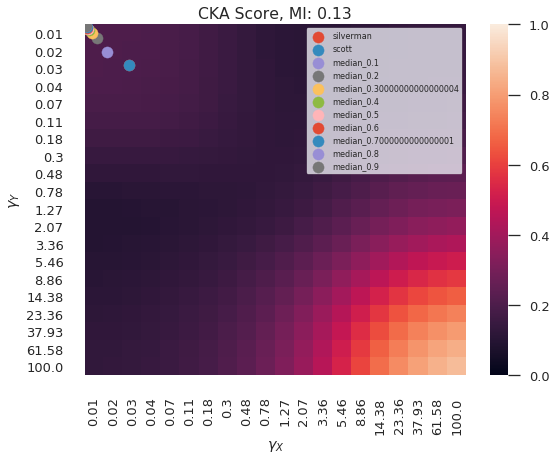

In [172]:

# ==========================
# Centered Kernel Alignment
# ==========================
scorer = 'cka'

# Plot Grid
fig, ax = plot_gamma_grid(param_df, scorer=scorer)

# Plot points
ax = plot_estimated_params(ax, gamma_ests_df, gamma_estimators, scorer, )

ax.legend(ncol=1, fontsize=8)
ax.set_xlabel(r'$\gamma_X$')
ax.set_ylabel(r'$\gamma_Y$')
ax.set_title(f'{scorer.upper()} Score, MI: {inputs.mutual_info:.2f}')
plt.tight_layout()
plt.show()

### Viz - Combined Function


In [174]:
def plot_dist_params(param_df, gamma_ests_df, gamma_estimators, scorer: str):

    # Plot Grid
    fig, ax = plot_gamma_grid(param_df, scorer=scorer)

    # Plot points
    ax = plot_estimated_params(ax, gamma_ests_df, gamma_estimators, scorer, )

    ax.legend(ncol=1, fontsize=8)
    ax.set_xlabel(r'$\gamma_X$')
    ax.set_ylabel(r'$\gamma_Y$')
    ax.set_title(f'{scorer.upper()} Score, MI: {inputs.mutual_info:.2f}')
    plt.tight_layout()
    plt.show()

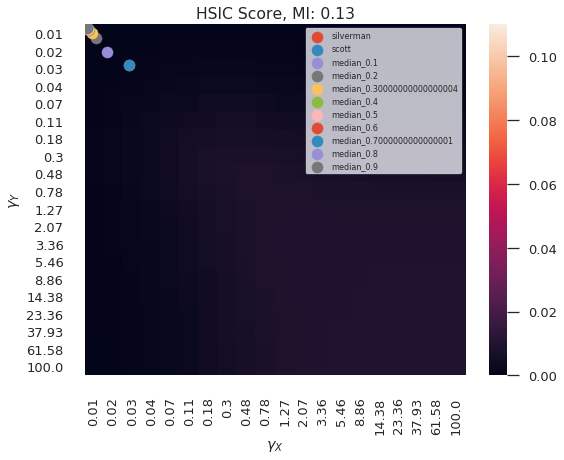

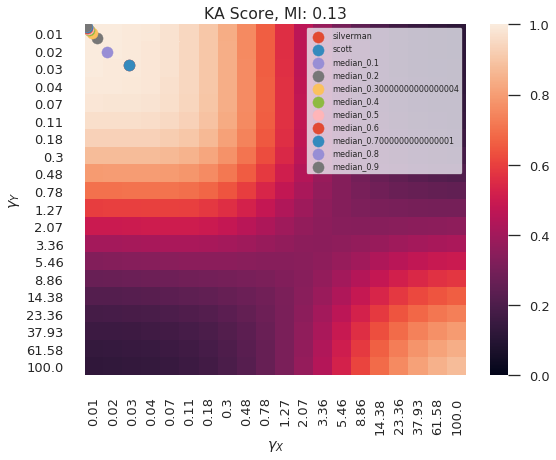

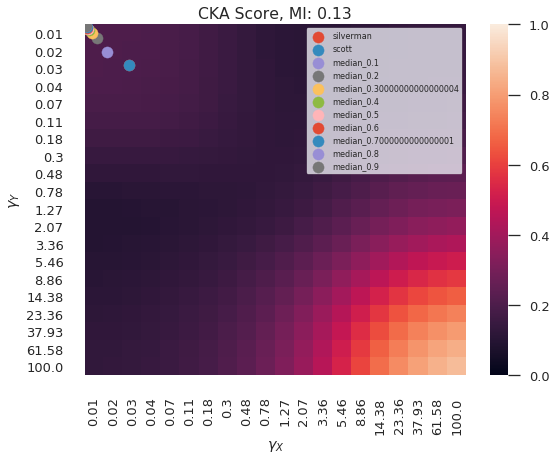

In [176]:

plot_dist_params(param_df, gamma_ests_df, gamma_estimators, 'hsic')
plot_dist_params(param_df, gamma_ests_df, gamma_estimators, 'ka')
plot_dist_params(param_df, gamma_ests_df, gamma_estimators, 'cka')


## Experiment II - Different Scorers, Initializations and Degree of Freedom

In this experiment, we'll be looking at how do the HSIC values change depending upon the gamma initialization as well as the degree of freedom we choose. In the Gaussian distribution, this is the standard deviation, $\sigma$ and the T-Student distribution this is the $\nu$ parameter.

In [25]:
from tqdm import trange, tqdm

In [27]:
# dataset params
dataset = 'gauss'
samples = 100
dimensions = 2
std = 1
trial = 1

# max params
n_gamma = 50
factor = 1

# experimental parameters
scorers = ['hsic', 'tka', 'ctka']
gamma_methods = [
    ('silverman',None),
    ('scott', None),
    ('median', None),
    ('belkin', 0.1),
    ('belkin', 0.2),
    ('belkin', 0.4),
    ('belkin', 0.8),
    ('max', None)
]
dof_params = np.linspace(1,11, 11, endpoint=True)

# results dataframe
results_df = pd.DataFrame()


# run experiment
with tqdm(gamma_methods) as gamma_bar:
    for imethod in gamma_bar:
        for iscorer in scorers:
            for idof in dof_params:

                # extract dataset
                X, Y, mi_val = MIData(dataset).get_data(samples=samples, dimensions=dimensions, std=int(idof), trial=trial)

                # initialize gamma
                if imethod[0] == 'max':
                    hsic_value = get_hsic(X, Y, iscorer, gamma_init, maximum=True, n_gamma=n_gamma, factor=factor)
                else:
                    gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1])
                    hsic_value = get_hsic(X, Y, iscorer, gamma_init)

                # append results to dataframe
                results_df = results_df.append({
                    'scorer': iscorer,
                    'gamma_method': f"{imethod[0]}_{imethod[1]}" if imethod[1] is not None else f"{imethod[0]}",
                    'gamma_init': gamma_init,
                    'hsic_value': hsic_value,
                    'std': idof,
                    'mi_value': mi_val,
                }, ignore_index=True)

results_df.head()

100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


,gamma_init,gamma_method,hsic_value,mi_value,scorer,std
0,2.320794,silverman,0.008088,0.000000,hsic,1.0
1,2.320794,silverman,0.008068,0.002053,hsic,2.0
2,2.320794,silverman,0.008096,0.007718,hsic,3.0
3,2.320794,silverman,0.008163,0.016467,hsic,4.0
4,2.320794,silverman,0.008259,0.027999,hsic,5.0


In [61]:
# plot the results
from typing import Tuple, List, Optional
def plot_scorer_mi(df: pd.DataFrame, scorer: str, dataset: str, omit_methods: Optional[Tuple[str, List[str]]]=None)-> None:
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    
    # extract dataset
    df = df[df['dataset'] == dataset]
    
    # omit methods
    if omit_methods is not None:
        df = df[~df[omit_methods[0]].isin(omit_methods[1])]
    
    # plot
    sns.scatterplot(
        x='hsic_value', 
        y='mi_value',
        hue='gamma_method',
        data=df[df['scorer'] == scorer],
        ax=ax
    )
    ax.set_ylabel('Mutual Information')
    ax.set_xlabel('Score')
    ax.legend(prop={'size':9})
    ax.set_title(scorer.upper())
    plt.show()

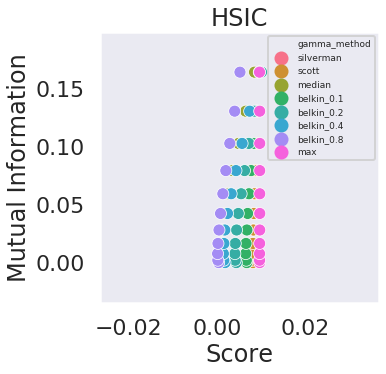

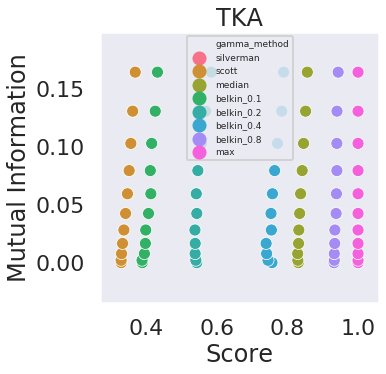

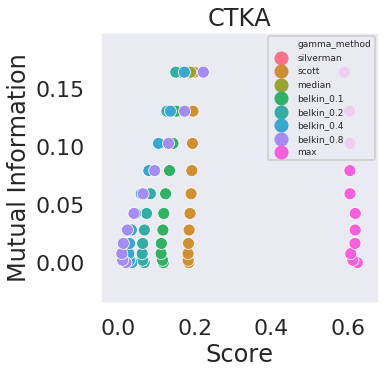

In [29]:
plot_scorer_mi(results_df, 'hsic')
plot_scorer_mi(results_df, 'tka')
plot_scorer_mi(results_df, 'ctka')

### Same Experiment, but with a higher number of samples and dimensions

In [70]:
# dataset params
datasets = ['tstudent', 'gauss']
samples = [100, 500]
dimensions = [2]
trials = [1]

# max params
n_gamma = 50
factor = 1

# experimental parameters
scorers = ['hsic', 'tka', 'ctka']
gamma_methods = [
    ('silverman',None),
    ('scott', None),
    ('median', None),
    ('belkin', 0.1),
    ('belkin', 0.2),
    ('belkin', 0.4),
    ('belkin', 0.8),
    ('max', None)
]
std_params = np.linspace(1,11, 11, endpoint=True, dtype=int)
nu_params = np.linspace(1,9, 9, endpoint=True, dtype=int)

# results dataframe
results_df = pd.DataFrame()



        
# loop through datasets
for idataset in datasets:
    # run experiment
    with tqdm(gamma_methods) as gamma_bar:

        # Loop through Gamma params
        for imethod in gamma_bar:
            # Loop through samples
            for isample in samples:
                
                # Loop through dimensions
                for idim in dimensions:
                    
                    # Loop through trials
                    for itrial in trials:
                        
                        # Loop through HSIC scorers
                        for iscorer in scorers:

                            # extract dataset
                            if idataset == 'gauss':
                                dof_params = std_params
                            else:
                                dof_params = nu_params
                            
                            # Loop through dof params
                            for idof in dof_params:
                                
                                X, Y, mi_val = MIData(idataset).get_data(samples=isample, dimensions=idim, std=idof, nu=idof, trial=itrial)

                                # initialize gamma
                                if imethod[0] == 'max':
                                    hsic_value = get_hsic(X, Y, iscorer, gamma_init, maximum=True, n_gamma=n_gamma, factor=factor)
                                else:
                                    gamma_init = get_gamma_init(X, Y, imethod[0], imethod[1])
                                    hsic_value = get_hsic(X, Y, iscorer, gamma_init)

                                # append results to dataframe
                                results_df = results_df.append({
                                    'dataset': idataset,
                                    'samples': isample,
                                    'dimensions': idim,
                                    'trial': itrial,
                                    'scorer': iscorer,
                                    'gamma_method': f"{imethod[0]}_{imethod[1]}" if imethod[1] is not None else f"{imethod[0]}",
                                    'gamma_init': gamma_init,
                                    'hsic_value': hsic_value,
                                    'dof': idof,
                                    'mi_value': mi_val,
                                }, ignore_index=True)
                            
                    postfix = dict(Samples=f"{isample}", Dimensions=f"{idim}")
                    gamma_bar.set_postfix(postfix)

results_df.head()

100%|██████████| 8/8 [00:32<00:00,  4.05s/it, Samples=500, Dimensions=2]


,dataset,dimensions,dof,gamma_init,gamma_method,hsic_value,mi_value,samples,scorer,trial
0,tstudent,2.0,1.0,2.320794,silverman,0.009819,0.302042,100.0,hsic,1.0
1,tstudent,2.0,2.0,2.320794,silverman,0.008801,0.136519,100.0,hsic,1.0
2,tstudent,2.0,3.0,2.320794,silverman,0.008473,0.079458,100.0,hsic,1.0
3,tstudent,2.0,4.0,2.320794,silverman,0.008517,0.052638,100.0,hsic,1.0
4,tstudent,2.0,5.0,2.320794,silverman,0.008267,0.037823,100.0,hsic,1.0


In [71]:
res_high_df = results_df.copy()

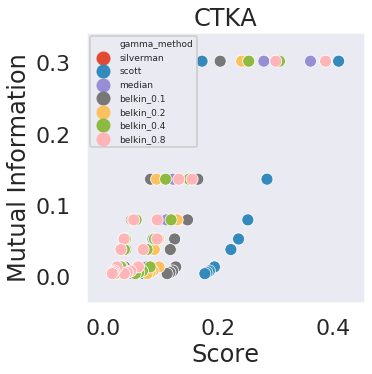

In [75]:
plot_scorer_mi(res_high_df, 'ctka', 'tstudent', ('gamma_method', ['max', ]))
# plot_scorer_mi(res_high_df, 'tka', 'tstudent')
# plot_scorer_mi(res_high_df, 'ctka', 'tstudent')